In [23]:
import torch
from torch.nn import BCELoss
from sklearn.model_selection import train_test_split

from utils_data import *
from utils_classification import MultiLayerPerceptron
from utils_training import Trainer
from utils_running import Runner
from utils_evaluation import evaluate_tensor
from utils_plot import plot_confusion_matrix, plot_roc

In [24]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = "mps"

In [25]:
data = PopulationData().load_raw('../../data/raw/train.csv')
data.encode_normalized_age()
data.encode_normalized_constitution()
data.encode_normalized_behavior()
# data.encode_standardized_age()
# data.encode_standardized_constitution()
# data.encode_standardized_behavior()
data.encode_connection_lists()
data.encode_graph_nx()
data.encode_degree()
# data.encode_degree_centrality()
# data.encode_clustering_coefficient()
data.encode_normalized_degree()
# data.encode_normalized_degree_centrality()
# data.encode_normalized_clustering_coefficient()
# data.encode_standardized_degree()
# data.encode_standardized_degree_centrality()
# data.encode_standardized_clustering_coefficient()
# data.encode_connected_index_patient()
data.encode_distance_to_index_patient()
data.encode_normalized_distance_to_index_patient()
# data.encode_standardized_distance_to_index_patient()
data.encode_sum_neighbor_age()
data.encode_sum_neighbor_constitution()
data.encode_sum_neighbor_behavior()
data.encode_sum_neighbor_degree()
# data.encode_sum_neighbor_degree_centrality()
# data.encode_sum_neighbor_clustering_coefficient()
data.encode_normalized_sum_neighbor_age()
data.encode_normalized_sum_neighbor_constitution()
data.encode_normalized_sum_neighbor_behavior()
data.encode_normalized_sum_neighbor_degree()
# data.encode_normalized_sum_neighbor_degree_centrality()
# data.encode_normalized_sum_neighbor_clustering_coefficient()
# data.encode_standardized_sum_neighbor_age()
# data.encode_standardized_sum_neighbor_constitution()
# data.encode_standardized_sum_neighbor_behavior()
# data.encode_standardized_sum_neighbor_degree()
# data.encode_standardized_sum_neighbor_degree_centrality()
# data.encode_standardized_sum_neighbor_clustering_coefficient()
# data.encode_mean_neighbor_age()
# data.encode_mean_neighbor_constitution()
# data.encode_mean_neighbor_behavior()
# data.encode_mean_neighbor_degree()
# data.encode_mean_neighbor_degree_centrality()
# data.encode_mean_neighbor_clustering_coefficient()
# data.encode_normalized_mean_neighbor_age()
# data.encode_normalized_mean_neighbor_constitution()
# data.encode_normalized_mean_neighbor_behavior()
# data.encode_normalized_mean_neighbor_degree()
# data.encode_normalized_mean_neighbor_degree_centrality()
# data.encode_normalized_mean_neighbor_clustering_coefficient()
# data.encode_standardized_mean_neighbor_age()
# data.encode_standardized_mean_neighbor_constitution()
# data.encode_standardized_mean_neighbor_behavior()
# data.encode_standardized_mean_neighbor_degree()
# data.encode_standardized_mean_neighbor_degree_centrality()
# data.encode_standardized_mean_neighbor_clustering_coefficient()
data.encode_test_train()

In [26]:
features = ['Normalized_Age',
            'Normalized_Constitution',
            'Normalized_Behaviour',
            'Normalized_Degree',
            'Normalized_Distance_to_Index_Patient',
            'Normalized_Sum_Neighbor_Age',
            'Normalized_Sum_Neighbor_Constitution',
            'Normalized_Sum_Neighbor_Behaviour',
            'Normalized_Sum_Neighbor_Degree']
train_features, train_labels = data.get_data_numpy(features=features, train='Train')
test_features, test_labels = data.get_data_tensors(features=features, train='Test')
test_features, test_labels = test_features.to(device), test_labels.to(device)

In [27]:
train_features, eval_features, train_labels, eval_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)
eval_features = torch.tensor(eval_features, dtype=torch.float32).to(device)
eval_labels = torch.tensor(eval_labels, dtype=torch.float32).to(device)
train_dataset = PopulationDataset(train_features, train_labels)
eval_dataset = PopulationDataset(eval_features, eval_labels)
test_dataset = PopulationDataset(test_features, test_labels)

In [28]:
hidden_sizes = [64, 32, 16]
activations = ['relu', 'relu', 'relu']
model = MultiLayerPerceptron(input_size=len(features),
                             hidden_sizes=hidden_sizes,
                             activations=activations,
                             output_activation='sigmoid')

In [29]:
criterion = BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, criterion, optimizer)
trainer.train(train_dataset, eval_dataset, batch_size=32, num_epochs=50, device=device)

100%|██████████| 50/50 [15:00<00:00, 18.01s/it]

Best model found at epoch 44 with evaluation loss: 0.6713


In [30]:
trainer.test(test_dataset, batch_size=32, device=device)

Test loss: 0.6698


In [31]:
runner = Runner(model)
test_predicted = runner.predict(test_dataset, batch_size=32, device=device).to(device)
test_probabilities = runner.predict_proba(test_dataset, batch_size=32, device=device).to(device)
accuracy, precision, recall, f1, auc_roc, confusion_matrix = evaluate_tensor(test_predicted, test_probabilities, test_labels, device=device)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.5874
Precision: 0.5727
Recall: 0.4787
F1: 0.5215
AUC-ROC: 0.6153


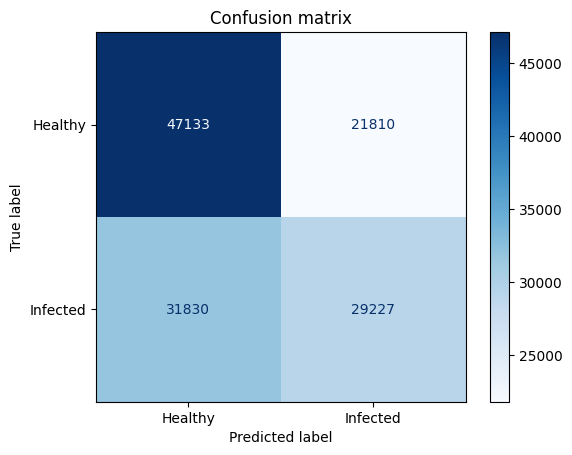

In [32]:
plot_confusion_matrix(confusion_matrix, ['Healthy', 'Infected'])

In [33]:
plot_roc(test_probabilities.numpy(), test_labels.numpy())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.